In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools

In [5]:
root_dir = os.path.dirname(os.getcwd())
export_dir = os.path.join(root_dir, 'export')
df = pd.read_csv(os.path.join(export_dir, 'measurement_files_metadata.csv'))

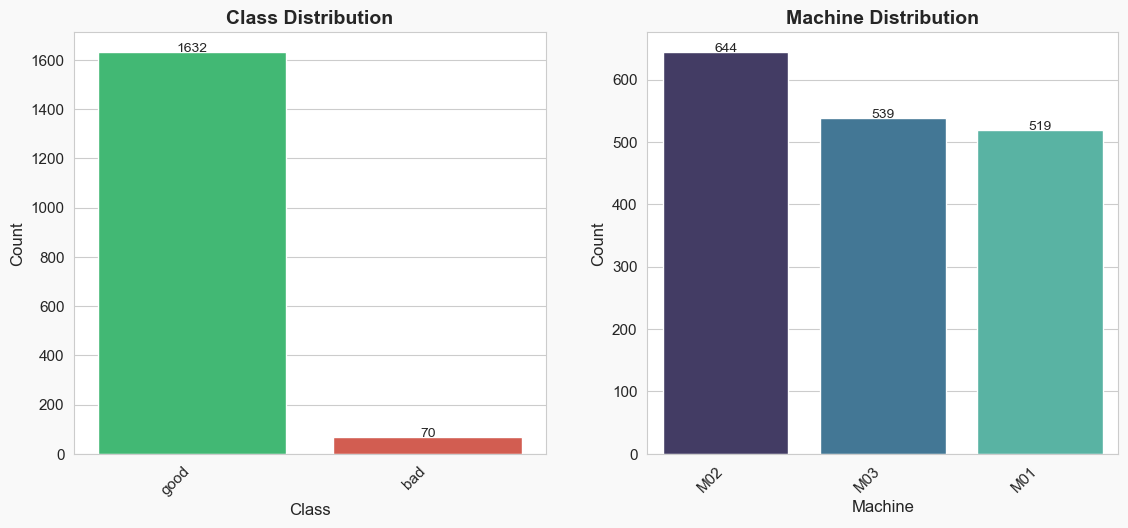

Class Distribution (%):
  good: 95.89%
  bad: 4.11%

Machine Distribution (%):
  M02: 37.84%
  M03: 31.67%
  M01: 30.49%


In [6]:
# Check the class distribution (imbalance)
plt.figure(figsize=(12, 6), facecolor='#f9f9f9')
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

# Create a custom color palette - using the same colors as in the next figure
class_colors = {'good': '#2ecc71', 'bad': '#e74c3c'}
colors = [class_colors[cls] for cls in df['class'].unique()]

# Plot class distribution
plt.subplot(1, 2, 1)
class_counts = df['class'].value_counts().sort_values(ascending=False)
ax1 = sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette=colors, legend=False)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 0.1, str(v), ha='center', fontsize=10)

# Plot machine distribution
plt.subplot(1, 2, 2)
machine_counts = df['machine'].value_counts().sort_values(ascending=False)
machine_colors = sns.color_palette("mako", n_colors=len(df['machine'].unique()))
ax2 = sns.barplot(x=machine_counts.index, y=machine_counts.values, hue=machine_counts.index, palette=machine_colors, legend=False)
plt.title('Machine Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Machine', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
# Add count labels on top of bars
for i, v in enumerate(machine_counts.values):
    ax2.text(i, v + 0.1, str(v), ha='center', fontsize=10)

plt.tight_layout(pad=3.0)
# Save the figure to the export directory
plt.savefig(os.path.join(export_dir, 'distribution_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display percentage distribution for better understanding
print("Class Distribution (%):")
class_pct = df['class'].value_counts(normalize=True).mul(100).round(2).sort_values(ascending=False)
for cls, pct in class_pct.items():
    print(f"  {cls}: {pct}%")

print("\nMachine Distribution (%):")
machine_pct = df['machine'].value_counts(normalize=True).mul(100).round(2).sort_values(ascending=False)
for machine, pct in machine_pct.items():
    print(f"  {machine}: {pct}%")


<Figure size 1400x800 with 0 Axes>

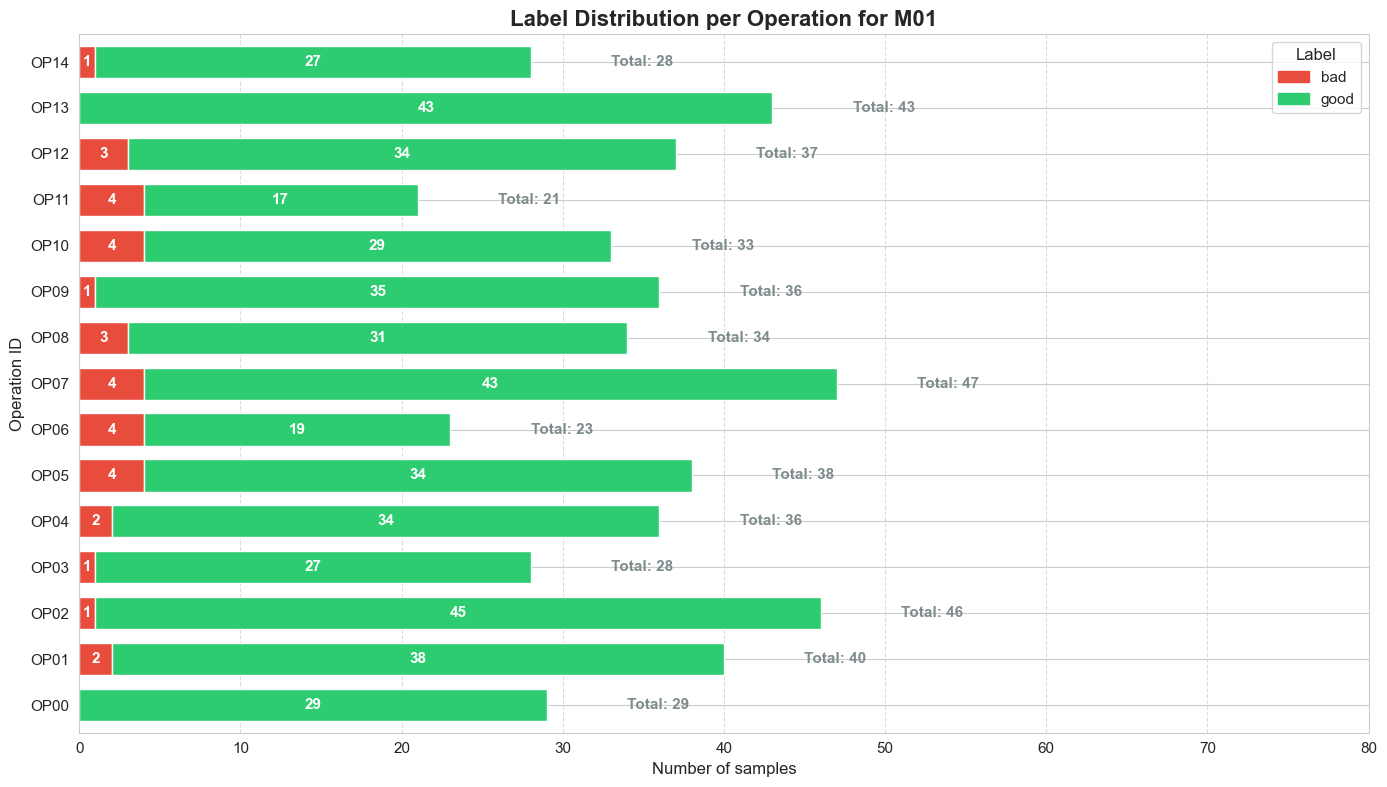

<Figure size 1400x800 with 0 Axes>

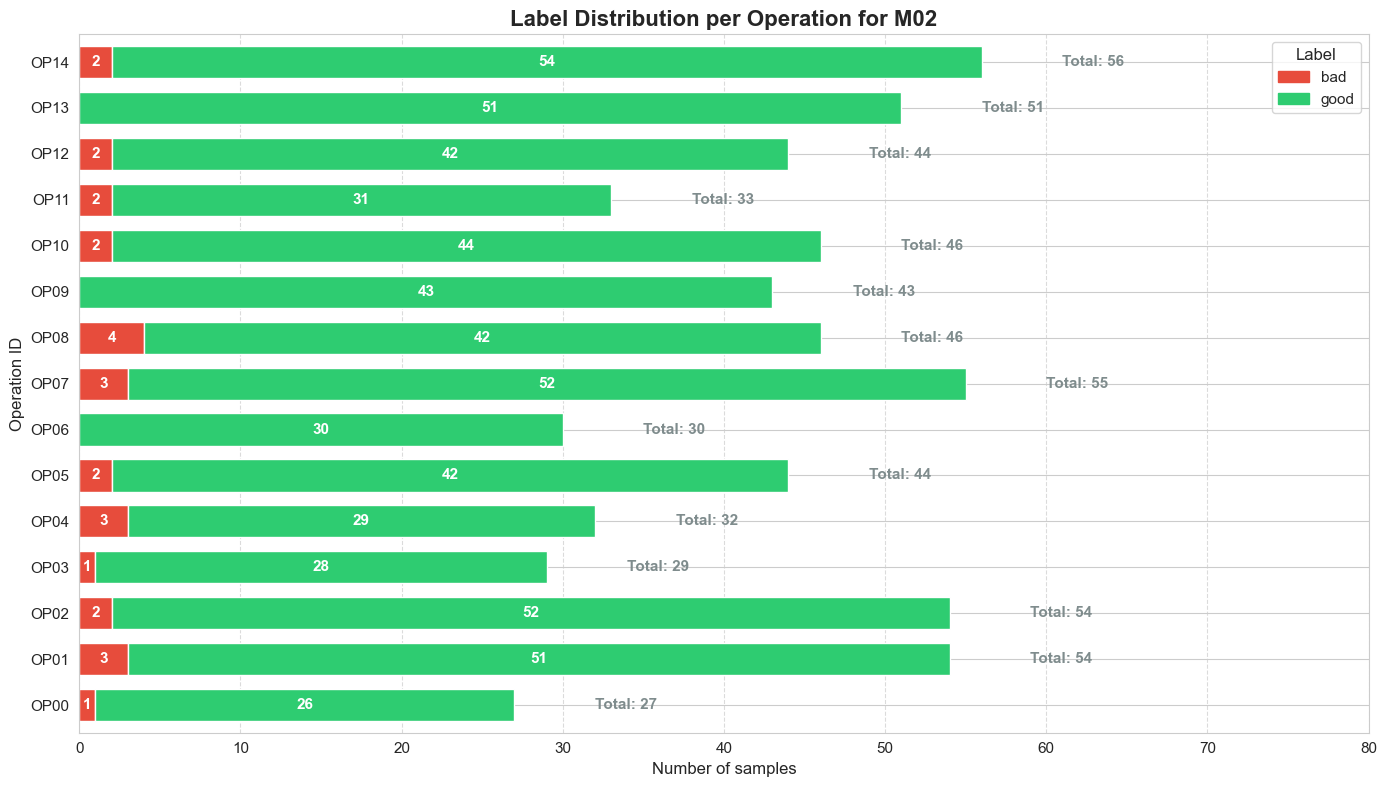

<Figure size 1400x800 with 0 Axes>

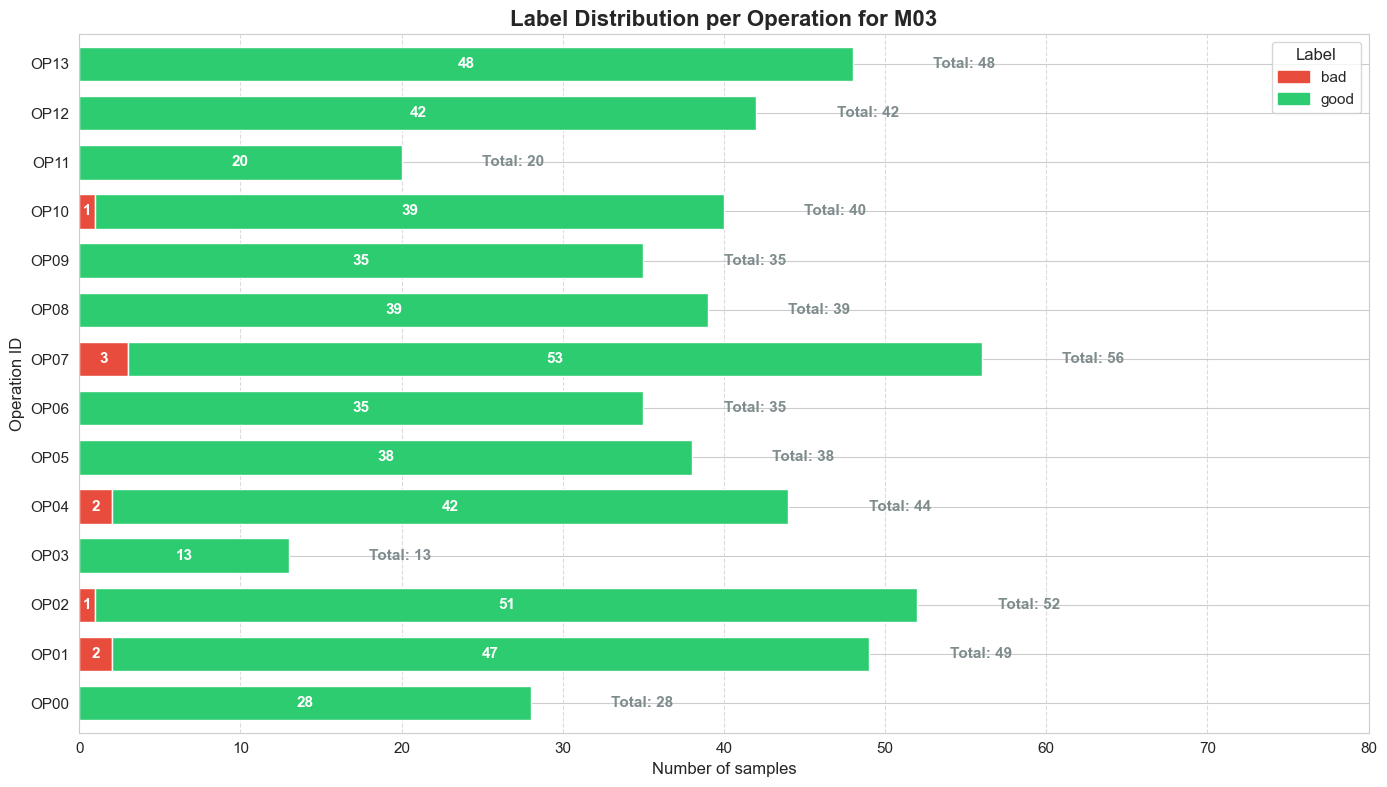

<Figure size 1400x800 with 0 Axes>

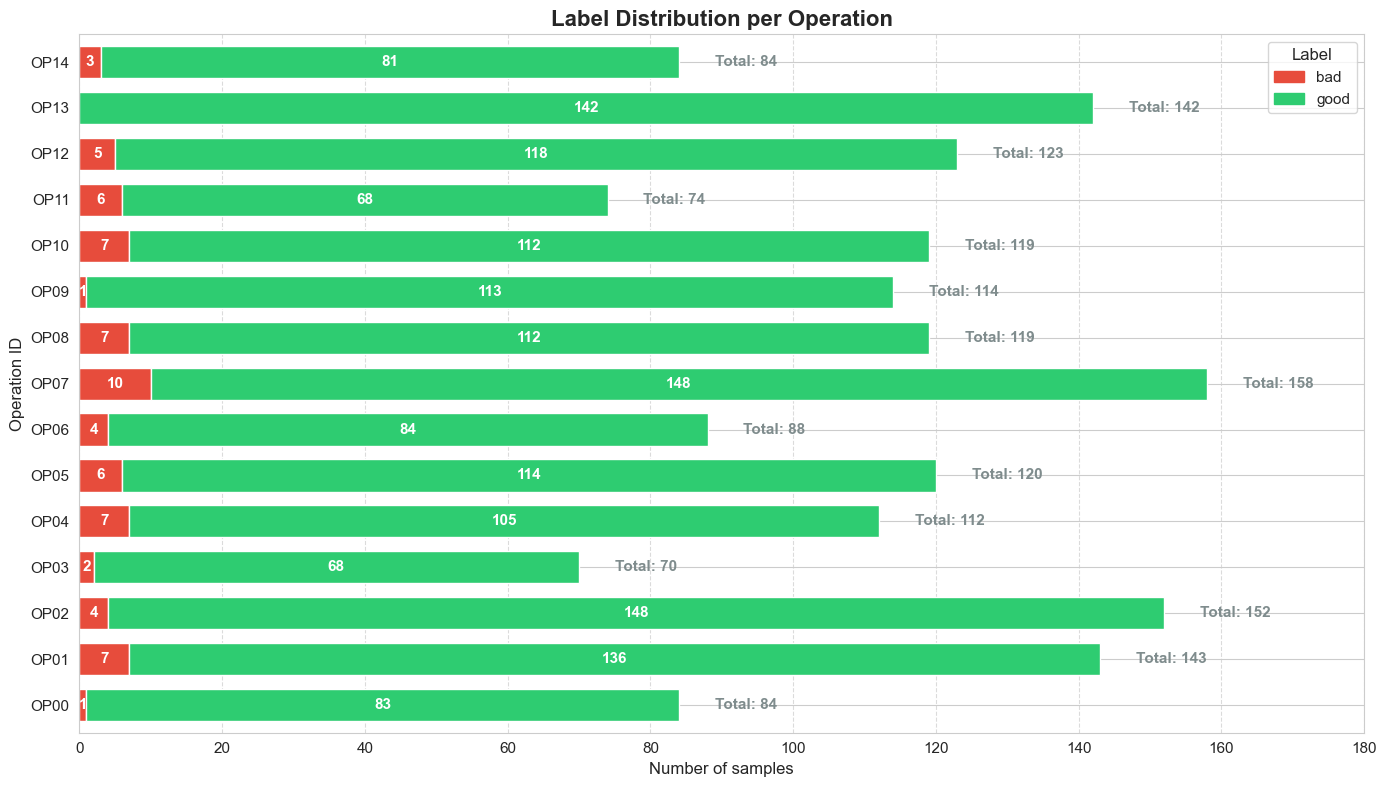

In [7]:
def plot_operation_distribution(df, machine=None, export_dir=None,xlim=80):
    """
    Plot operation distribution for a specific machine or all machines.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing the data
    machine : str, optional
        If specified, only plot data for this machine
    export_dir : str, optional
        Directory to save the plot
    """
    # Filter data for specific machine if provided
    if machine:
        plot_df = df[df['machine'] == machine].copy()
        title_suffix = f' for {machine}'
    else:
        plot_df = df.copy()
        title_suffix = ''

    # Create a bar chart visualization with custom colors
    plt.figure(figsize=(14, 8), facecolor='#f9f9f9')

    # Create pivot table
    pivot_df = pd.crosstab(plot_df['operation'], plot_df['class'], margins=True, margins_name='Total')

    # Sort operations
    pivot_df['op_id'] = pivot_df.index.str.extract(r'(\d+)').astype(float)
    pivot_df = pivot_df.sort_values(by='op_id', ascending=False)
    pivot_df = pivot_df.drop('op_id', axis=1)
    
    if 'Total' in pivot_df.index:
        total_row = pivot_df.loc['Total']
        pivot_df = pivot_df.drop('Total')
        pivot_df.loc['Total'] = total_row

    # Prepare data for plotting
    pivot_for_plot = pivot_df.drop('Total', axis=1).drop('Total', axis=0)

    # Define custom colors
    class_colors = {'good': '#2ecc71', 'bad': '#e74c3c', 'Total': '#7f8c8d'}
    colors = [class_colors.get(col, '#3498db') for col in pivot_for_plot.columns]

    # Create plot
    ax = pivot_for_plot.plot(kind='barh', stacked=True, color=colors, figsize=(14, 8), width=0.7)

    # Create custom legend
    handles = [plt.Rectangle((0,0),1,1, color=class_colors[label]) for label in pivot_for_plot.columns if label in class_colors]
    labels = [label for label in pivot_for_plot.columns if label in class_colors]

    other_labels = [label for label in pivot_for_plot.columns if label not in class_colors]
    if other_labels:
        for label in other_labels:
            handles.append(plt.Rectangle((0,0),1,1, color='#3498db'))
            labels.append(label)

    plt.legend(handles, labels, title='Label', title_fontsize=12)

    plt.title(f'Label Distribution per Operation{title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Number of samples', fontsize=12)
    plt.ylabel('Operation ID', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(0, xlim)

    # Add labels
    for i, (idx, row) in enumerate(pivot_for_plot.iterrows()):
        cumulative = 0
        for col in pivot_for_plot.columns:
            if row[col] > 0:
                x_pos = cumulative + row[col]/2
                ax.text(x_pos, i, f"{int(row[col])}", 
                       ha='center', va='center', 
                       color='white', fontweight='bold')
            cumulative += row[col]
        
        total = pivot_df.loc[idx, 'Total']
        ax.text(cumulative + 5, i, f"Total: {int(total)}", 
               ha='left', va='center', 
               color='#7f8c8d', fontweight='bold')

    plt.tight_layout()
    
    if export_dir:
        filename = f'operation_class_barchart{"_" + machine if machine else ""}.png'
        plt.savefig(os.path.join(export_dir, filename), dpi=300, bbox_inches='tight', pad_inches=0.2)
    
    plt.show()

# Plot for each machine separately
for machine in df['machine'].unique():
    plot_operation_distribution(df, machine=machine, export_dir=export_dir)

# Plot overall distribution
plot_operation_distribution(df, export_dir=export_dir,xlim=180)
